In [2]:
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from librosa import display
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

# Load the spreadsheet, choose only the best quality recordings and add an identifier string to each entry
allbirds = pd.read_csv("AllBirdsv4.csv",header=0)
allbirds = allbirds[allbirds["Quality"] == "A"]
allbirds["identifier"] = allbirds["File ID"].astype(str) + " (" + allbirds["Vocalization_type"] + " - "+ allbirds["English_name"] + ")"

# Helper function to take data from the imported spreadsheet and find the associated .mp3 file
def getFilename(fileid,English_name):
    return "All Birds/" + str.replace(str.replace(English_name,"-"," ").title()," ","-") + "-" + str(fileid) + ".mp3"

# Processes the results of the interactive widget for selecting a sound file
def f(Sound1,Sound2):
    result1 = allbirds[allbirds["File ID"].astype(str) == Sound1.split(" ")[0]]
    result2 = allbirds[allbirds["File ID"].astype(str) == Sound2.split(" ")[0]]
    
    result1 =  getFilename(str(result1["File ID"].iloc[0]),str(result1["English_name"].iloc[0]))
    result2 =  getFilename(str(result2["File ID"].iloc[0]),str(result2["English_name"].iloc[0]))
    
    return (result1,result2)
    
# Widget for selecting two bird sounds to compare
w = interactive(f, Sound1=list(allbirds["identifier"]), Sound2=list(allbirds["identifier"]))
display(w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnU291bmQxJywgb3B0aW9ucz0oJzQwNjE3MSAoY2FsbCAtIFJvc2UtY3Jlc3RlZCBCbHVlIFBpcGl0KScsICc0MDXigKY=


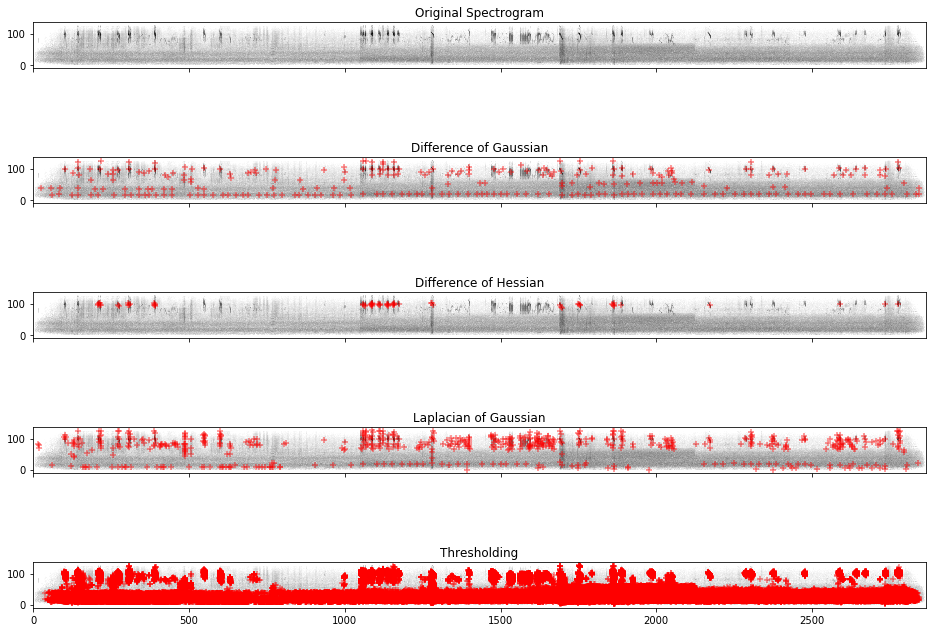

In [6]:
# This cell contains a number of alternative functions used for generating constellation plots

# Import the skimage libraries that support generation of the constellation plots
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

ms = 10
th = 6

# Function to create a spectrogram
def getSpecgram(file_path):
    y, sr = librosa.load(file_path)
    D = librosa.stft(y)
    S = librosa.feature.melspectrogram(y, sr=sr)
    logS = librosa.power_to_db(abs(S))
    img_bw = rgb2gray(logS)
    return 255-img_bw

# Fucntion to plot the spectrogram on the passed axis
def plotSpecgram(axis,file_path):
    axis.imshow(getSpecgram(file_path),origin="lower",cmap=plt.cm.gray)
    axis.set_title("Original Spectrogram")

# Function to plot the 'difference of hessian' output on the passed axis
def plot_doh(axis,file_path,color="red"):
    blobs = blob_doh(255-getSpecgram(file_path), max_sigma=1, threshold=0.1)
    axis.scatter(blobs[:,1],blobs[:,0],marker="+",color=color,alpha=0.5)
    axis.set_title("Difference of Hessian")

# Function to plot the 'difference of gaussian' output on the passed axis
def plot_dog(axis,file_path,color="red"):
    blobs = blob_dog(255-getSpecgram(file_path), max_sigma=ms, threshold=th)
    axis.scatter(blobs[:,1],blobs[:,0],marker="+",color=color,alpha=0.5)
    axis.set_title("Difference of Gaussian")

# Function to plot the 'laplacian of gaussian' output on the passed axis
def plot_log(axis, file_path,color="red"):
    blobs = blob_log(255-getSpecgram(file_path), max_sigma=ms, threshold=th)
    axis.scatter(blobs[:,1],blobs[:,0],marker="+",color=color,alpha=0.5)
    axis.set_title("Laplacian of Gaussian")

# Identify the threshold approach peaks
def get_thresholding(file_path):
    img = getSpecgram(file_path)
    blobs = []
    for y in range(len(img)):
        for x in range(len(img[y])):
            if img[y,x] < 290: blobs.append([x,y])
    
    blobs_np = np.array(blobs)
    return blobs_np

# Plot the threshold approach peaks on the passed axis
def plot_thresholding(axis, file_path):
    blobs_np = get_thresholding(file_path)
    axis.scatter(blobs_np[:,0],blobs_np[:,1],marker="+",color="red",alpha=0.5)
    axis.set_title("Thresholding")


# Create a single plot with five subplots, each showing a different approach to generating the constellation plot

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(16,12), sharex=True, sharey=True)

selectedSound = w.result[0]

plotSpecgram(ax1,selectedSound)

plotSpecgram(ax2,selectedSound)
plot_dog(ax2,selectedSound)

plotSpecgram(ax3,selectedSound)
plot_doh(ax3,selectedSound)

plotSpecgram(ax4,selectedSound)
plot_log(ax4,selectedSound)

plotSpecgram(ax5,selectedSound)
plot_thresholding(ax5,selectedSound)

plt.show()


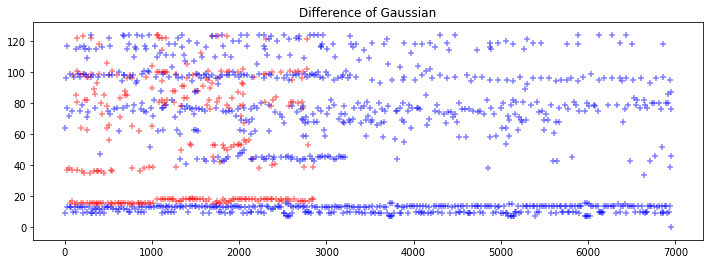

In [7]:
# Show how the output of two constellation plots on the same axis

f, ax1 = plt.subplots(1, figsize=(12,4), sharex=True, sharey=True)
plot_dog(ax1,w.result[0],color="red")
plot_dog(ax1,w.result[1],color="blue")

In [8]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Button
from bokeh.plotting import figure, output_file, show

output_file("callback.html")

def getBlob(file_path):
    return blob_dog(255-getSpecgram(file_path), max_sigma=ms, threshold=th)

constellationPlot1 = getBlob(w.result[0])
x1 = constellationPlot1[:,1]
y1 = constellationPlot1[:,0]

constellationPlot2 = getBlob(w.result[1])
x2 = constellationPlot2[:,1]
y2 = constellationPlot2[:,0]

source = ColumnDataSource(data=dict(x=x1, y=y1))

plot = figure(plot_width=800, plot_height=400)
plot.square_cross('x', 'y', source=source, size = 12, fill_color=None,line_color="red")

source2 = ColumnDataSource(data=dict(x=x2, y=y2))

plot.square_cross('x', 'y', source=source2, size = 12, fill_color=None,line_color="blue")

callback_left = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = 2
        var x = data['x']
        var y = data['y']
        for (var i = 0; i < x.length; i++) {
            x[i] = x[i] - f
        }
        
        source.change.emit();
    """)

callback_right = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = 2
        var x = data['x']
        var y = data['y']
        for (var i = 0; i < x.length; i++) {
            x[i] = x[i] + f
        }
        
        source.change.emit();
    """)


callback_up = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = 2
        var x = data['x']
        var y = data['y']
        for (var i = 0; i < x.length; i++) {
            y[i] = y[i] + f
        }
        
        source.change.emit();
    """)

callback_down = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = 2
        var x = data['x']
        var y = data['y']
        for (var i = 0; i < x.length; i++) {
            y[i] = y[i] - f
        }
        
        source.change.emit();
    """)

button_left = Button(label="Move Left", callback=callback_left, name="Left")
button_right = Button(label="Move Right", callback=callback_right, name="Right")
button_up = Button(label="Move Up", callback=callback_up, name="Up")
button_down = Button(label="Move Down", callback=callback_down, name="Down")

layout = column(button_left,button_right,button_up,button_down, plot)

show(layout)